# Abyss NMEAOut Analysis

This notebook shows how to turn an Abyss Nmea Out log into tables for analysis

In [1]:
import pathlib, pandas as pd, sys, os
import matplotlib.pyplot as plt
sys.path.append(str(pathlib.Path.cwd().parent / "src"))  # for local import

In [2]:
from adcp_parser import parse_file, save_tables_html

In [3]:
RAW_FILE = "../data/01_06_2025.txt"   # drop your .txt here

In [4]:
ca, cs = parse_file(RAW_FILE)
ca.head(), cs.head()

(    bin    date    time  depth_m speed_ms direction_deg            datetime
 0  BIN0  010625  001902   25.122     0.45         191.5 2025-06-01 00:19:02
 1  BIN0  010625  003902   25.070     0.55         187.4 2025-06-01 00:39:02
 2  BIN0  010625  005902   25.183     0.51         188.5 2025-06-01 00:59:02
 3  BIN0  010625  011902   25.242     0.53         181.5 2025-06-01 01:19:02
 4  BIN0  010625  013902   25.195     0.52         177.9 2025-06-01 01:39:02,
     bin    date    time  depth_m speed_ms direction_deg            datetime
 0  BIN1  010625  001445   45.413     0.35          96.7 2025-06-01 00:14:45
 1  BIN2  010625  001445   55.413     0.41          74.9 2025-06-01 00:14:45
 2  BIN3  010625  001445   65.413     0.33          74.5 2025-06-01 00:14:45
 3  BIN4  010625  001445   75.413     0.25          56.1 2025-06-01 00:14:45
 4  BIN5  010625  001445   85.413      0.3          29.5 2025-06-01 00:14:45)

In [5]:
print(cs)

         bin    date    time  depth_m speed_ms direction_deg  \
0       BIN1  010625  001445   45.413     0.35          96.7   
1       BIN2  010625  001445   55.413     0.41          74.9   
2       BIN3  010625  001445   65.413     0.33          74.5   
3       BIN4  010625  001445   75.413     0.25          56.1   
4       BIN5  010625  001445   85.413      0.3          29.5   
...      ...     ...     ...      ...      ...           ...   
18671  BIN25  090625  223445  285.425     <NA>          <NA>   
18672  BIN26  090625  223445  295.425     <NA>          <NA>   
18673  BIN27  090625  223445  305.425     <NA>          <NA>   
18674  BIN28  090625  223445  315.425     <NA>          <NA>   
18675  BIN29  090625  223445  325.425     <NA>          <NA>   

                 datetime  
0     2025-06-01 00:14:45  
1     2025-06-01 00:14:45  
2     2025-06-01 00:14:45  
3     2025-06-01 00:14:45  
4     2025-06-01 00:14:45  
...                   ...  
18671 2025-06-09 22:34:45  
18672 2

In [6]:
from adcp_parser import parse_file, save_tables_html

save_tables_html(ca, cs,
                 out_dir="html",                      # folder will be created
                 css_path="../styles/tables.css")     # the stylesheet we generated



<h1> Comparing Bins
<h3> Here we take all BINS (From Aquadopp and ADCP Signature) order them in depth in time domain. Then we make some simple analysis on the data validity frequency and compare some BINs
<h4> This comparison spans over 

In [7]:
from adcp_parser import parse_file
from adcp_grids  import build_metric_grids

speed_mat, dir_mat = build_metric_grids(ca, cs, max_bin=29)

display(speed_mat)     # or .style.format("{:.2f}")


,2025-06-01 00:14:45,2025-06-01 00:34:45,2025-06-01 00:54:45,2025-06-01 01:14:45,2025-06-01 01:34:45,2025-06-01 01:54:45,2025-06-01 02:14:45,2025-06-01 02:34:45,2025-06-01 02:54:45,2025-06-01 03:14:45,...,2025-06-09 19:34:45,2025-06-09 19:54:45,2025-06-09 20:14:45,2025-06-09 20:34:45,2025-06-09 20:54:45,2025-06-09 21:14:45,2025-06-09 21:34:45,2025-06-09 21:54:45,2025-06-09 22:14:45,2025-06-09 22:34:45
BIN0,0.45,0.55,0.51,0.53,0.52,0.57,0.5,0.48,0.45,0.55,...,0.5,0.46,0.45,0.46,0.48,0.5,0.49,0.54,0.48,0.45
BIN1,0.35,0.38,0.24,0.27,0.35,0.39,0.46,0.53,0.51,0.59,...,0.25,0.21,0.2,0.28,0.23,0.26,0.3,0.28,0.3,0.25
BIN2,0.41,0.44,0.33,0.28,0.28,0.35,0.34,0.36,0.37,0.46,...,0.21,0.2,0.19,0.19,0.22,0.19,0.18,0.24,0.15,0.13
BIN3,0.33,0.37,0.35,0.29,0.26,0.29,0.3,0.29,0.26,0.3,...,0.18,0.18,0.17,0.19,0.19,0.18,0.2,0.21,0.23,0.19
BIN4,0.25,0.27,0.33,0.29,0.28,0.21,0.25,0.27,0.3,0.29,...,0.17,0.13,0.12,0.12,0.16,0.17,0.17,0.24,0.23,0.2
BIN5,0.3,0.3,0.25,0.25,0.29,0.21,0.24,0.23,0.27,0.28,...,0.19,0.15,0.14,0.18,0.2,0.27,0.22,0.23,0.31,0.23
BIN6,0.4,0.37,0.28,0.27,0.31,0.29,0.23,0.24,0.22,0.27,...,0.18,0.15,0.17,0.21,0.15,0.23,0.23,0.21,0.3,0.31
BIN7,0.5,0.48,0.37,0.39,0.46,0.43,0.33,0.34,0.3,0.38,...,0.13,0.12,0.15,0.17,0.13,0.16,0.19,0.14,0.23,0.26
BIN8,0.55,0.58,0.49,0.52,0.62,0.57,0.49,0.49,0.46,0.52,...,0.11,0.09,0.09,NaN,NaN,NaN,NaN,0.13,0.18,0.19
BIN9,0.6,0.64,0.61,0.64,0.71,0.67,0.64,0.65,0.63,0.65,...,0.07,0.08,0.08,NaN,NaN,NaN,NaN,0.15,0.21,0.22


In [8]:
# Check how many valid points each bin has in the window you’re plotting
import numpy as np, pandas as pd

window = speed_mat   # or _slice_window(speed_mat, START, END) if you set a window
for b in ["BIN0", "BIN1"]:
    finite = window.loc[b].notna().sum()
    print(f"{b:4s}  has {finite} finite points")


BIN0  has 631 finite points
BIN1  has 595 finite points


<H1> Comparator Cell
<h3> Comparing Aquadopp current meter bin (BIN0) to ADCP first BIN (BIN1)

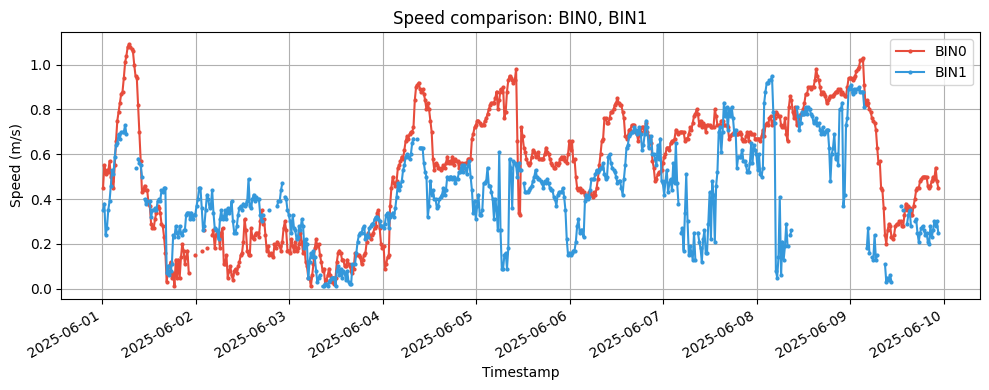

In [9]:
from adcp_stats import compare_bins

# ▶︎ Compare two bins in the speed matrix
BINS  = ["BIN0", "BIN1"]
# START = "2025-05-30 21:00:00"
# END   = "2025-05-30 22:00:00"

compare_bins(speed_mat, bins=BINS,     markersize=2,            
    linewidth=1.5,                    
    colors=["#e74c3c", "#3498db", "#2ecc71"],  
)

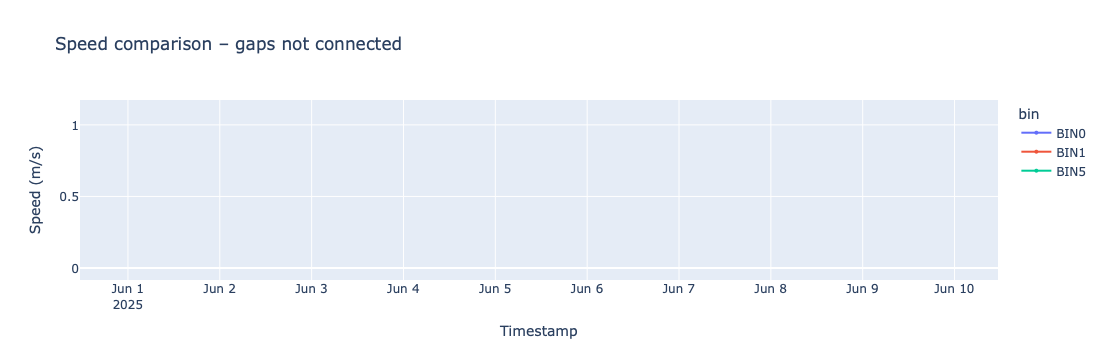

In [10]:
# ╔═╡  Interactive compare_bins  — break at NaNs ╞══════════════════════════════
import plotly.express as px
import pandas as pd

# ─── PARAMETERS ──────────────────────────────────────────────────────────────
BINS   = ["BIN0", "BIN1", "BIN5"]         # choose up to any number of bins
START  = None                             # eg "2025-05-30 00:00:00"
END    = None                             # eg "2025-05-31 23:59:59"
# ─────────────────────────────────────────────────────────────────────────────

# helper from earlier
def _slice_window(df, start=None, end=None):
    if start: df = df.loc[:, df.columns >= pd.to_datetime(start)]
    if end:   df = df.loc[:, df.columns <= pd.to_datetime(end)]
    return df

df = _slice_window(speed_mat, START, END).reindex(index=BINS)

# ─── KEEP NaNs!  (NO .dropna()) ──────────────────────────────────────────────
tidy = (
    df
    .T.reset_index()
    .melt(id_vars="index", var_name="bin", value_name="speed_ms")
    .rename(columns={"index": "timestamp"})
    # .dropna()   ← removed!  gaps remain, so connectgaps will be honoured
)

fig = px.line(
    tidy,
    x="timestamp",
    y="speed_ms",
    color="bin",
    title="Speed comparison – gaps not connected",
    markers=True,               # circles on each valid sample
)

# break the line across NaNs (default in Plotly = True)
fig.update_traces(
    connectgaps=False,          # <- THIS now works because NaNs were kept
    marker_size=4
)
fig.update_yaxes(title="Speed (m/s)")
fig.update_xaxes(title="Timestamp")
fig.show()


<h1> Validity Report Cell

In [11]:
from adcp_stats import validity_report

# BINS  = ["BIN0", "BIN5", "BIN10"]       # None → all bins
# START = "2025-05-30 21:00:00"
# END   = "2025-05-30 22:00:00"

report_df = validity_report(speed_mat, ) #bins=BINS
display(report_df.style.format("{:.1f}"))


,invalid_cnt,total_cnt,valid_pct
BIN0,13.0,644.0,98.0
BIN1,49.0,644.0,92.4
BIN2,27.0,644.0,95.8
BIN3,12.0,644.0,98.1
BIN4,5.0,644.0,99.2
BIN5,23.0,644.0,96.4
BIN6,21.0,644.0,96.7
BIN7,20.0,644.0,96.9
BIN8,30.0,644.0,95.3
BIN9,34.0,644.0,94.7


<h1> Histogram of Percentage of Valid data per Bin

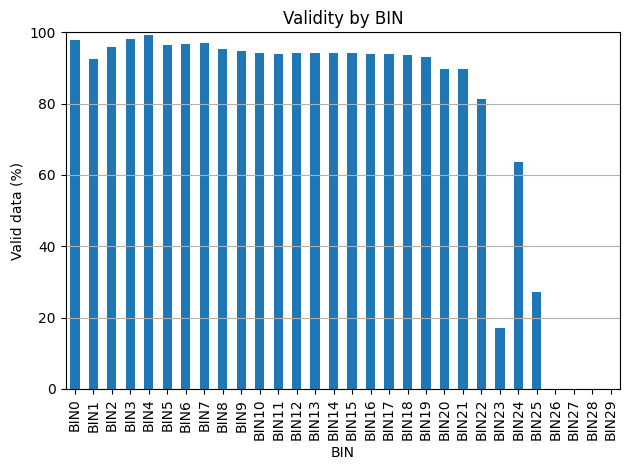

In [12]:
from adcp_stats import histogram_validity

# START = "2025-05-30 21:00:00"
# END   = "2025-05-30 22:00:00"

histogram_validity(speed_mat)


## Checking the the frequency of invalid data over each hour of the day

,invalid_bins
2025-06-07 06:14:45,25
2025-06-07 06:34:45,25
2025-06-07 05:54:45,25
2025-06-07 05:34:45,25
2025-06-07 03:34:45,24
2025-06-01 14:14:45,24
2025-06-07 05:14:45,24
2025-06-07 04:14:45,24
2025-06-07 03:54:45,24
2025-06-07 06:54:45,24


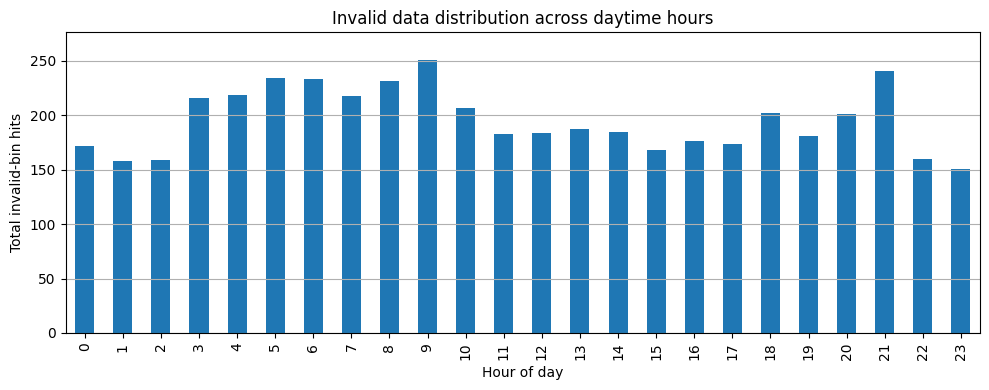

In [13]:
# ╔═╡  Rank “worst” time-frames + histogram by hour-of-day ╞═════════════════════
import matplotlib.pyplot as plt
import pandas as pd
from adcp_stats import _slice_window      # internal helper is fine to import

# ─── parameters you can tweak ────────────────────────────────────────────────
START      = None                 # e.g. "2025-05-30 00:00:00"
END        = None                 # e.g. "2025-06-01 23:59:59"
TOP_N      = 15                   # how many worst timestamps to list
# ─────────────────────────────────────────────────────────────────────────────

# 1) focus on the requested time-window
win = _slice_window(speed_mat, start=START, end=END)

# 2) count invalid bins at each timestamp
invalid_per_ts = win.isna().sum(axis=0)        # Series: index = timestamp
invalid_per_ts.name = "invalid_bins"

# 3) ranking – biggest ‘holes’ first
top = invalid_per_ts.sort_values(ascending=False).head(TOP_N)
display(top.to_frame().style.set_caption(f"Top {TOP_N} timestamps with most invalid bins"))

# 4) histogram → aggregate by hour-of-day (0-23)
hourly_sum = (
    invalid_per_ts
    .groupby(invalid_per_ts.index.hour)
    .sum()                         # total invalid-bin hits in each hour slot
)

ax = hourly_sum.plot.bar(figsize=(10,4))
ax.set_xlabel("Hour of day")
ax.set_ylabel("Total invalid-bin hits")
ax.set_title("Invalid data distribution across daytime hours")
ax.set_ylim(0, hourly_sum.max()*1.1)
ax.grid(True, axis="y")
plt.tight_layout()


<h2> Invalid Data Correlation between BINs

,BIN0,BIN1,BIN2,BIN3,BIN4,BIN5,BIN6,BIN7,BIN8,BIN9,BIN10,BIN11,BIN12,BIN13,BIN14,BIN15,BIN16,BIN17,BIN18,BIN19,BIN20,BIN21,BIN22,BIN23,BIN24,BIN25,BIN26,BIN27,BIN28,BIN29
BIN0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.92,0.77,1.00,1.00,1.00,1.00,1.00
BIN1,0.00,1.00,0.02,0.06,0.00,0.02,0.04,0.02,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.08,0.06,0.12,0.29,0.82,0.35,0.67,1.00,1.00,1.00,1.00
BIN2,0.00,0.04,1.00,0.04,0.04,0.15,0.15,0.22,0.26,0.26,0.26,0.26,0.26,0.26,0.26,0.26,0.26,0.26,0.26,0.26,0.33,0.37,0.37,0.74,0.30,0.48,1.00,1.00,1.00,1.00
BIN3,0.00,0.25,0.08,1.00,0.08,0.17,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.17,0.08,0.25,1.00,0.58,0.25,1.00,1.00,1.00,1.00
BIN4,0.00,0.00,0.20,0.20,1.00,0.80,0.60,0.80,0.80,0.80,0.80,0.80,0.80,0.80,0.80,0.80,0.80,0.80,0.80,0.80,0.80,0.80,0.80,1.00,0.20,0.60,1.00,1.00,1.00,1.00
BIN5,0.00,0.04,0.17,0.09,0.17,1.00,0.57,0.57,0.57,0.57,0.57,0.57,0.57,0.57,0.57,0.57,0.57,0.57,0.57,0.57,0.57,0.52,0.57,0.96,0.39,0.70,1.00,1.00,1.00,1.00
BIN6,0.00,0.10,0.19,0.05,0.14,0.62,1.00,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.67,0.71,1.00,0.14,0.57,1.00,1.00,1.00,1.00
BIN7,0.00,0.05,0.30,0.05,0.20,0.65,0.75,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.95,0.80,0.95,0.10,0.35,1.00,1.00,1.00,1.00
BIN8,0.00,0.07,0.23,0.03,0.13,0.43,0.50,0.67,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.97,0.87,0.93,0.30,0.40,1.00,1.00,1.00,1.00
BIN9,0.00,0.06,0.21,0.03,0.12,0.38,0.44,0.59,0.88,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.97,0.88,0.94,0.26,0.41,1.00,1.00,1.00,1.00


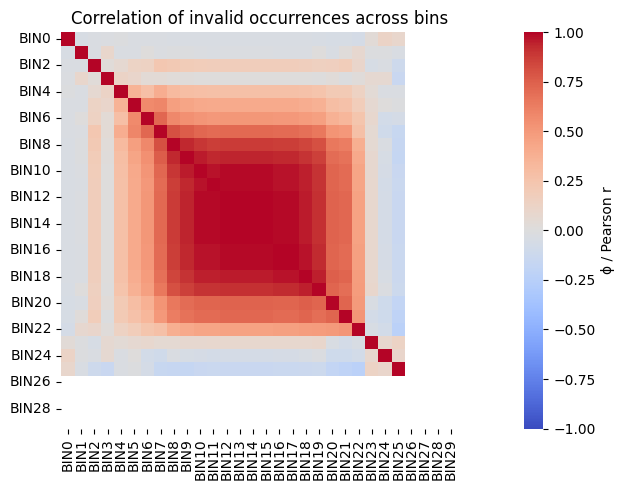

In [14]:
# ╔═╡  Correlation / co-occurrence of invalid bins ╞═══════════════════════════
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from adcp_stats import _slice_window        # reuse helper; or slice manually

# ─── PARAMETERS ──────────────────────────────────────────────────────────────
BINS  = None                 # e.g. ["BIN0","BIN1","BIN5"]  or None = all
START = None                 # e.g. "2025-05-30 00:00:00"
END   = None                 # e.g. "2025-06-02 23:59:59"
# ─────────────────────────────────────────────────────────────────────────────

win = _slice_window(speed_mat, START, END)
if BINS is not None:
    win = win.reindex(index=BINS)

invalid = win.isna()                         # bool DataFrame: True = invalid
bins    = invalid.index
n_bins  = len(bins)

# ── 1) Conditional-probability matrix  P(j invalid | i invalid)  ────────────
cond_df = pd.DataFrame(index=bins, columns=bins, dtype=float)

for i in bins:
    denom = invalid.loc[i].sum()            # #timestamps where bin i invalid
    if denom == 0:
        cond_df.loc[i] = np.nan
        continue
    for j in bins:
        joint = (invalid.loc[i] & invalid.loc[j]).sum()
        cond_df.loc[i, j] = joint / denom

display(cond_df.style.format("{:.2f}")
                    .set_caption("Conditional probability "
                                 "P(bin j invalid | bin i invalid)"))

# ── 2) ϕ / Pearson correlation of invalid flags  ────────────────────────────
phi_df = invalid.T.corr(method="pearson")    # phi coefficient for binary vars

# ── 3) Heat-map  ─────────────────────────────────────────────────────────────
plt.figure(figsize=(6 + 0.25*n_bins, 5))
sns.heatmap(phi_df, vmin=-1, vmax=1, cmap="coolwarm",
            square=True, cbar_kws={"label": "ϕ / Pearson r"})
plt.title("Correlation of invalid occurrences across bins")
plt.yticks(rotation=0); plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# 🚦 Análise de Co-ocorrência de Dados Inválidos entre Bins

> **Propósito**  
> Verificar se os *buracos de dados* tendem a acontecer **ao mesmo tempo** em diferentes bins do ADCP.  


---

## Intuição

1. **Mapa de probabilidades condicionais**  
   *Para cada bin-i*, medimos a fração de vezes em que **pelo menos um outro bin-j** também estava inválido **na mesma amostra de tempo**.  
   * Leitura: se `P(BIN7 inválido | BIN3 inválido) = 0,75`, significa que, em 75 % das vezes em que o BIN 3 falhou, o BIN 7 falhou junto.

2. **Matriz de correlação ϕ (Pearson para variáveis binárias)**  
   *Transformamos* a tabela `speed_mat` em um DataFrame booleano (`True → NaN`, `False → valor válido`).  
   * Calculamos ϕ (= correlação de Pearson para 0/1).  
   * ϕ ≈ 1 → os dois bins compartilham quase sempre o mesmo estado (válido/ inválido).  
   * ϕ ≈ 0 → falhas independentes.  
   * ϕ < 0 → pouco provável aqui; indicaria que um falha quando o outro não falha.

3. **Heat-map**  
   Cores quentes (vermelho) destacam pares de bins que apresentam *muitas* falhas simultâneas; bons candidatos a investigação conjunta.



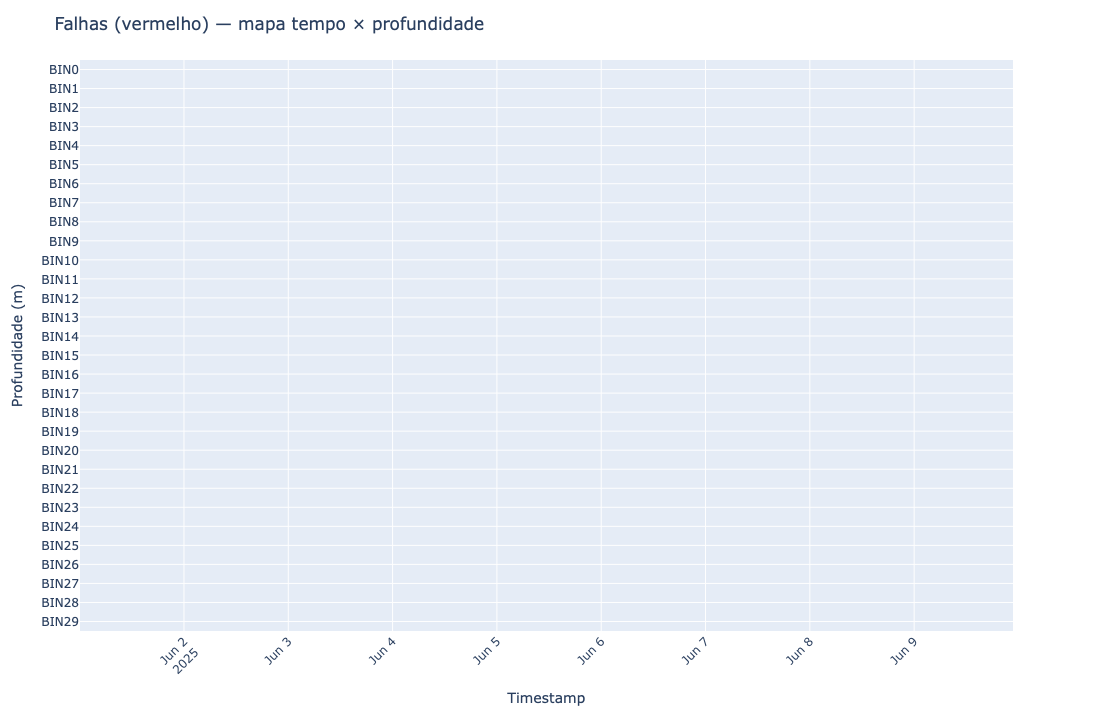

In [15]:
import plotly.express as px

# transforma booleano → inteiro (0 válido, 1 inválido)
z = invalid.astype(int)

fig = px.imshow(
    z,
    aspect="auto",
    color_continuous_scale=[[0, "green"], [1, "red"]],
    origin="upper",
    labels=dict(x="Timestamp", y="Profundidade (m)", color="Inválido"),
)

fig.update_yaxes(autorange="reversed")       # profundidade crescente para baixo
fig.update_xaxes(tickangle=-45)

fig.update_layout(
    title="Falhas (vermelho) — mapa tempo × profundidade",
    coloraxis_showscale=False,
    height=700,                                # ← canvas alto
    # width=1200,                                # (opcional) controlando largura
)
fig.show()
